In [18]:
import sys
sys.path.append('../../ABEL/')
from abel import *
import numpy as np
import time
import scipy.constants as SI 
import abel.utilities.plasma_physics as pp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 # [m]
driver.num_particles = 100000
driver.jitter.x = 0 # [m] 2e-6
driver.jitter.y = 0 # [m] 100e-9
driver.jitter.t = 0 # 10e-15 # [m]
driver.symmetrize = True
driver.seed = 1
#drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######


# define stage
stage = StageQuasistatic2d()
#stage = StagePrtclTransWakeInstability()                      #######
#stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.length = 20000 # [m]
stage.nom_energy_gain = 31.9e9/(11/stage.length) # [eV]
stage.plasma_density = 2e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.radiation_reaction = True
stage.save_evolution = False
if stage.radiation_reaction == False:
    stage.save_evolution = False

# define first stage (half length)
first_stage = StageQuasistatic2d()
#first_stage = StagePrtclTransWakeInstability()                      #######
#first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.radiation_reaction = stage.radiation_reaction
first_stage.save_evolution = stage.save_evolution

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 1500e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.01
source.bunch_length = 10e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 50000
source.jitter.t = driver.jitter.t
source.symmetrize = True
source.seed = driver.seed
#beam = source.track()


# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1.  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
#linac.first_stage = first_stage
#linac.interstage = interstage
linac.num_stages = 1
shots = 1

In [45]:
# scan the driver timing jitter
spread = np.logspace(np.log10(0.01),np.log10(0.2),8)
linac.scan(f'scan_spread_RR_{stage.radiation_reaction}', 
           lambda obj, val: setattr(obj.source, 'rel_energy_spread', val) or obj, 
           spread,
           label='Relative energy spread [%]',
           scale=1e-2,
           num_shots_per_step=1, 
           parallel=True,
           overwrite=True);

Output()

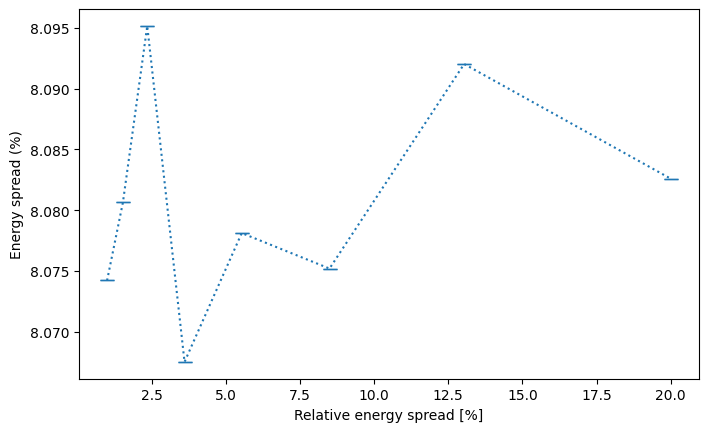

In [46]:
linac.plot_beam_function(Beam.rel_energy_spread, label='Energy spread (%)', scale=1e-2, xscale='linear')